In [39]:
import sys

sys.path.append("../functions")

from Utils import *
from Plotting import *
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
# from sklearn.linear_model import LinearRegression
# import seaborn as sns
import warnings
import seaborn
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats
from scipy.special import logsumexp
from itertools import product
from functools import partial
from multiprocessing import Pool


In [40]:
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
data = raw_data[["sub", "condition", "cresp", "resp", "cj","cor", "phase", "trial", "trial_rev","reward", "Lreward", "Hreward" ]]
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]

# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]
subjects = lv_induction_data["sub"].unique()

In [41]:
def get_log_transition_prob(d):
    if d < 18:
        return -np.inf
    else :
        return np.log(1/5)

In [42]:
def get_log_emission_prob(actions, rewards, state):
    log_emission_prob = 0 
    high_reward_dist = scipy.stats.norm(60, 8)
    low_reward_dist = scipy.stats.norm(40, 8)
    if state ==0:
        log_emission_prob += np.sum(high_reward_dist.logpdf(rewards[actions==0]))
        log_emission_prob += np.sum(low_reward_dist.logpdf(rewards[actions==1]))
    else: 
        log_emission_prob += np.sum(high_reward_dist.logpdf(rewards[actions==1]))
        log_emission_prob += np.sum(low_reward_dist.logpdf(rewards[actions==0]))
    return log_emission_prob

In [43]:
def compute_sequences(sub_data, t, d):
    """
    Slices the data from (t-d) to (t-1) inclusive.
    """
    return (
        sub_data["resp"][t-d:t].to_numpy(),
        sub_data["reward"][t-d:t].to_numpy() * 100,
    )


In [44]:
def linear_transform_on_array(input_array, domain_range, codomain_range):
    """Linearly transforms an array from one range to another."""
    xl, xu = domain_range
    yl, yu = codomain_range
    scale = (yu - yl) / (xu - xl) if xl != xu else 0
    return np.where(xl != xu, ((input_array - xl) * scale) + yl, yl)

def model_subj_conf_dist(params, confs, resp_probs):
    lbound, scale = params[0], params[1]
    hbound = scale * (5 - lbound) + lbound
    model_confs = linear_transform_on_array(resp_probs, [0, 1], [lbound, hbound])
    return np.mean((confs - model_confs) ** 2)

def forward_pass(dist_params, sub_data, alpha_log, T, durations, num_states):
    """
    Vectorizes over durations so that for each t,
    alpha_log has shape (T+1, num_states, D).
    durations is shape (D,) e.g. [1, 2, ..., 22].
    """
    D = len(durations)
    
    # 1) Precompute transition for all durations
    #    shape = (D,)
    
#     transition_log = np.array([get_log_transition_prob(d) for d in durations])
    dist = scipy.stats.nbinom(*dist_params)
    transition_log = dist.logpmf(durations)
    transition_log = transition_log - logsumexp(transition_log)

    # 2) Precompute emission for all t, states, durations
    #    shape => (T+1, num_states, D)
    emission_log = np.full((T+1, num_states, D), 0)
    
    for t in range(1, T+1):
        for i, d in enumerate(durations):
            prev_t = t - d
            if prev_t < 0:
                continue  # invalid, remains -inf
            actions_seq, reward_seq = compute_sequences(sub_data, t, d)
            for s in range(num_states):
                emission_log[t, s, i] = get_log_emission_prob(actions_seq, reward_seq, s)

    # 3) Now do the forward recursion
    for t in range(1, T + 1):
        idx = t - durations  # shape=(D,)
        
        valid_mask = (idx >= 0)
        
        alpha_prev = np.full((D, num_states), -np.inf)
        
        alpha_prev[valid_mask] = logsumexp(
            alpha_log[idx[valid_mask], :, :], axis=-1
        )
        
        alpha_prev = alpha_prev[:, ::-1]  # If you really need to flip states
        
        alpha_log[t] = (
            alpha_prev.T                    # shape => (num_states, D)
            + transition_log[np.newaxis, :] # shape => (1, D)
            + emission_log[t]               # shape => (num_states, D)
        )

    return transition_log, emission_log, alpha_log

def run_hmm_inference(dist_params, sub_data):
    """
    Example of how you'd call the vectorized forward pass.
    For demonstration, only the alpha update is shown.
    """
    # 1) Slice data for the chosen subject
    T = len(sub_data)

    # 2) Initialize alpha uniformly
    num_states = 2
    durations = np.arange(1,  71)  # 1..70
    D = len(durations)

    alpha = np.zeros((T + 1, num_states, D))
    alpha[0, :, :] = 1.0
    alpha[0, :, :] /= np.sum(alpha[0, :, :])
    alpha_log = np.log(alpha)

    # 3) Run forward pass (vectorized over durations)
    p, e, log_alpha = forward_pass(dist_params, sub_data, alpha_log, T, durations, num_states)
    alpha = logsumexp(log_alpha, axis=-1)
    
    T, S, D = e.shape

    # Create indices for t, s, d, k
    t_indices = np.arange(1, T+1 ).reshape(-1, 1, 1, 1)  # (T, 1, 1, 1)
    s_indices = np.arange(S).reshape(1, -1, 1, 1)  # (1, S, 1, 1)
    d_indices = np.arange(1, D +1 ).reshape(1, 1, -1, 1)  # (1, 1, D, 1)
    k_indices = np.arange(1, D +1).reshape(1, 1, 1, -1)  # (1, 1, 1, D)
    
    e = np.pad(e, ((0, 0), (0, 0), (1, 0)), mode='constant', constant_values=0)
    # Compute t-k and mask invalid indices
    t_minus_k = t_indices - k_indices  # (T, 1, 1, D)
    valid_mask = t_minus_k >= 0  # (T, 1, 1, D)
    
    # Broadcast alpha, p, and e to match the dimensions
    prev_alpha = np.where(valid_mask, alpha[t_minus_k, s_indices], -np.inf)  # (T, S, D, D)
    prev_alpha = np.flip(prev_alpha, axis=1)
    p_broadcasted = p[d_indices - 1]  # (1, 1, D, 1)
    e_broadcasted = e[t_indices-1, s_indices, k_indices - 1]  # (T, S, 1, D)

    # Compute gamma
    gamma = prev_alpha + p_broadcasted + e_broadcasted  # (T, S, D, D)

    state_log_probs = logsumexp(gamma, axis=(2,3))
    sum_probs = logsumexp(state_log_probs, axis=1, keepdims=True)
    state_log_probs = state_log_probs - sum_probs
    
    state_log_probs = state_log_probs[:-1]
    subject_resps = sub_data["resp"].to_numpy()
    resps_log_prob = state_log_probs[np.arange(len(subject_resps)), subject_resps]
    neg_ll = - np.sum(resps_log_prob)
    resp_probs = np.exp(resps_log_prob)

    return neg_ll, dist_params, resp_probs


def fit_grid(sub_data):
    p_range = np.linspace(0.01, 0.99, 16)  
    n_range = np.linspace(0.01, 100, 16)
    
    # Create the grid using itertools.product
    grid = list(product(n_range, p_range))
    func = partial(run_hmm_inference, sub_data= sub_data)
    
    # Evaluate the function on the grid in parallel
    def parallel_grid_minimization(grid):
        with Pool(128) as pool:
            results = pool.map(func, grid)
        return results    
    # Perform grid minimization
    results = parallel_grid_minimization(grid)
    
#     return results

#     Find the parameters that minimize the function
    min_result = min(results, key=lambda t: t[0])
    
    resp_probs = min_result[2]
    params_ranges = [[1, 5], [0, 1]]
    
    results = [minimize(model_subj_conf_dist, x0=[np.random.uniform(*r) for r in params_ranges], args=(sub_data["cj"].to_numpy(),resp_probs), bounds=params_ranges) for _ in range(10)]
    best_result = min(results, key=lambda x: x.fun if x.success else np.inf)
    fit_res_conf, conf_dist_seq = best_result.x, [result.fun for result in results if result.success]
    
    fit_res_final = (*min_result[1], *fit_res_conf)
    return fit_res_final, min_result[0], min(conf_dist_seq)

def fit_subjects():
    results = []
    for i, sub in enumerate(subjects):
        print("subject", i)
        sub_data = lv_induction_data[lv_induction_data["sub"] == sub] 
        min_result = fit_grid(sub_data)
        results.append(min_result)
    return results
        

    

In [ ]:
%%time
res = fit_subjects()

subject 0


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 1


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 2


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 3


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 4


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 5


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 6


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 7


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 8


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 9


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 10


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 11


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 12


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 13


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 14


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 15


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 16


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 17


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 18


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 19


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

subject 20


/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: RuntimeWarning: divide by zero encountered in log
  alpha_log = np.log(alpha)
/tmp/ipykernel_3430396/1309429859.py:81: Runtime

In [ ]:
import pickle

with open("test", "wb") as fp:   #Pickling
    pickle.dump(res, fp)


In [23]:
df = pd.DataFrame(
    [(*item[0], item[1], item[2]) for item in res],
    columns=['n', 'p', 'lbound', 'scale', 'negll', 'conf_dist']
)
df['subject'] = subjects

df["hbound"] = (5 - df["lbound"]) * df["scale"] + df["lbound"]
df.to_csv("hsmm_forward.csv")

In [95]:
sub_id = 12
sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]] 

# neg_ll, state_probs= run_hmm_inference((60, .6), sub_data)


In [47]:
import os

# Dynamically set the number of threads to the number of CPU cores
num_threads = os.cpu_count()

In [48]:
num_threads

128

In [9]:
sub_data["resp"]

3198    0
3199    0
3200    0
3201    0
3202    0
       ..
3593    1
3594    1
3595    1
3596    1
3597    1
Name: resp, Length: 400, dtype: int64

In [10]:

np.min(state_probs[np.arange(400), sub_data["resp"].to_numpy()])

IndexError: index 399 is out of bounds for axis 0 with size 399

In [ ]:
def max_consecutive_elements(arr):
    if not arr:
        return 0  # Return 0 for an empty array
    
    max_count = 1  # Maximum streak length
    current_count = 1  # Current streak length

    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1]:  # Check if current element matches the previous
            current_count += 1
        else:
            max_count = max(max_count, current_count)  # Update max streak
            current_count = 1  # Reset current streak
    
    # Final check in case the longest streak is at the end of the array
    max_count = max(max_count, current_count)
    
    return max_count


In [12]:
forward_hsmm_df = pd.read_csv("../../Meta_meassure_refactor/results/forward_hsmm.csv")
forward_hsmm_df

,Unnamed: 0,n,p,lbound,scale,negll,conf_dist,subject,hbound
0,0,93.334,0.794000,3.735920,0.794302,47.728148,0.743929,45628,4.739981
1,1,100.000,0.794000,3.594764,0.668917,32.951445,0.401574,45640,4.534751
2,2,6.676,0.336667,3.148277,0.000000,223.361785,1.549730,45664,3.148277
3,3,6.676,0.336667,1.720713,0.753974,148.669469,0.752773,45682,4.193208
4,4,80.002,0.794000,3.270278,0.917979,93.397290,0.340700,45745,4.858126
5,5,6.676,0.271333,1.000000,0.909161,64.414080,0.786559,45760,4.636644
6,6,0.010,0.010000,1.607888,0.961157,75.583836,0.707389,45763,4.868239
7,7,86.668,0.794000,3.984532,0.958155,77.154918,0.203101,45805,4.957508
8,8,13.342,0.402000,1.103421,0.821636,103.728616,0.711147,45829,4.304991
9,9,6.676,0.402000,2.429462,0.691609,150.161206,1.044057,45964,4.207269


In [22]:
def get_emission_prob(actions, rewards):
    log_emission_prob = np.zeros((2))
    high_reward_dist = scipy.stats.norm(60, 8)
    low_reward_dist = scipy.stats.norm(40, 8)
    log_emission_prob[0] = np.sum(high_reward_dist.logpdf(rewards[actions==0])) + np.sum(low_reward_dist.logpdf(rewards[actions==1]))
    log_emission_prob[1] = np.sum(low_reward_dist.logpdf(rewards[actions==0])) + np.sum(high_reward_dist.logpdf(rewards[actions==1]))
    return log_emission_prob

def simulate_hsmm(inp):    
    subj, params = inp
    sub_data = lv_induction_data[lv_induction_data["sub"] == subj]
    
    cresps = sub_data["cresp"].to_numpy()
    lreward = sub_data["Lreward"].to_numpy()
    hreward = sub_data["Hreward"].to_numpy()
    

    T = len(sub_data)
    states = np.arange(2)
    durations = np.arange(1, 71) 
    
    n, p, lbound, hbound = params
    dist = scipy.stats.nbinom(n,p)
    transition_log = dist.logpmf(durations)
    transition_log = transition_log - logsumexp(transition_log)
    
    log_alpha = np.full((T+1,len(states)), -np.inf)
    log_alpha[0,:]= np.log(1/2)
    
    actions = -np.ones((T))
    rewards = -np.ones((T))
    choice_prob = -np.ones((T))
    
    for i,t in enumerate(range(1,T+1)):
        temp = np.full((len(states),len(durations)), -np.inf)
        for j,k in enumerate(durations):
            if t-k <0:
                continue
            if k-1 == 0:
                temp[:,j] = np.flip(log_alpha[t-k,:])
            else:
                actions_slice = actions[t-k:t-1]
                rewards_slice = rewards[t-k:t-1]
                temp[:,j] = np.flip(log_alpha[t-k, :]) + get_emission_prob(actions_slice,rewards_slice)
        state_log_prob = logsumexp(temp,axis=-1)
        state_log_prob = state_log_prob - logsumexp(state_log_prob)
        state_prob = np.exp(state_log_prob)
        actions[i] = np.random.choice([0,1], p=state_prob)
        rewards[i] = hreward[i] if actions[i] == cresps[i] else lreward[i]
        choice_prob[i] = state_prob[int(actions[i])]
       
        temp = np.full((len(states),len(durations)), -np.inf)
        for j,d in enumerate(durations):
            if t-d <0:
                continue
            else:
                actions_slice = actions[t-d:t]
                rewards_slice = rewards[t-d:t]
                temp[:,j] = np.flip(log_alpha[t-d, :])+ transition_log[j] + get_emission_prob(actions_slice,rewards_slice)
        log_alpha[t,:] = logsumexp(temp, axis=-1)
    confs =  linear_transform_on_array(choice_prob, [0,1], [lbound,hbound])
    return actions,rewards, confs, cresps

In [36]:
for run in range(5):
    params_list = [(item["subject"], (item["n"], item["p"], item["lbound"], item["hbound"])) for _, item in forward_hsmm_df.iterrows()]
    with Pool(128) as pool:
        results = pool.map(simulate_hsmm, params_list)
    for i,res in enumerate(results):
        actions,rewards, choice_prob, cresps = res
        df= pd.DataFrame(zip(actions,rewards, choice_prob, cresps), columns=["resp","rewards", "cj", "cresps"])
        df["reward"] = df["rewards"]/100
        df["subject"] = params_list[i][0]
        df["cor"] = (df["resp"] == df["cresps"]).astype(int)
        df["run"] = run
        dfs.append(df)
bayes_forward_simulation_df = pd.concat(dfs)

In [30]:
forward_simulation_df = pd.read_csv("../results/forward_simulation_df.csv")
forward_simulation_df

,Unnamed: 0,subject,run,resp,reward,cor,cj,Q1,Q2
0,0,45628,0,0,0.625872,1.0,4.650588,0.500000,0.500000
1,1,45628,0,0,0.531705,1.0,4.678600,0.625872,0.500000
2,2,45628,0,1,0.395744,0.0,4.642412,0.531705,0.500000
3,3,45628,0,0,0.657494,1.0,4.680150,0.531705,0.395744
4,4,45628,0,0,0.750121,1.0,4.691411,0.657494,0.395744
...,...,...,...,...,...,...,...,...,...
2159995,2159995,47743,99,1,0.727834,1.0,4.598782,0.228024,0.499049
2159996,2159996,47743,99,1,0.584612,1.0,4.613190,0.228024,0.727834
2159997,2159997,47743,99,1,0.590103,1.0,4.610013,0.228024,0.584612
2159998,2159998,47743,99,1,0.569270,1.0,4.610322,0.228024,0.590103


In [98]:
human_lv_df = lv_induction_data.rename(columns={"sub": "subject"})

def calculate_averages(df):
    """
    Group by 'subject' and calculate the mean of 'reward', 'cor', and 'cj'. 
    """
    return df.groupby("subject").agg({"reward": "mean", "cor": "mean", "cj": "mean"}).reset_index()

dataframes = [forward_simulation_df, human_lv_df, bayes_forward_simulation_df]
averaged_dataframes = [calculate_averages(df) for df in dataframes]

groups = ["Forward", "Empirical", "HSMM-Forward"]

avg_sim_df = merge_result_df(averaged_dataframes, groups, 200, subjects)

# Rename columns in the merged DataFrame
avg_sim_df.rename(columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"}, inplace=True)


Statistics for Empirical and Forward =7.0, p=2.407e-10
Statistics for HSMM-Forward and Empirical =686.5, p=9.818e-01
Statistics for Forward and HSMM-Forward =0.0, p=1.626e-10
mean Forward = 0.76
mean Empirical = 0.86
mean HSMM-Forward = 0.87


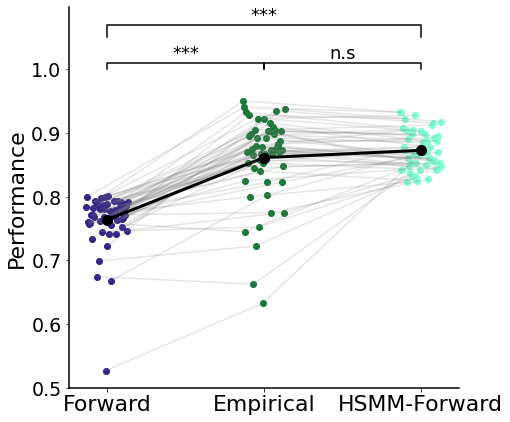

In [101]:
plt.figure(figsize=(7, 7))


groups = ["Forward", "Empirical", "HSMM-Forward"]

color_dict = {"HSMM-Forward": "#7FFFD4", "Forward": "#332288", "Empirical": "#117733"}

comparison_plot(
    avg_sim_df,
    "accuracy",
    groups,
    "",
    [["Empirical", "Forward"], ["HSMM-Forward", "Empirical"], ["Forward", "HSMM-Forward"]],
    [1, 1, 1.05],
    [0.01, 0.01, 0.02],
    y_label="Performance",
    color_dict = color_dict
)

In [38]:
bayes_forward_simulation_df.to_csv("../results/hsmm_forward_simulation_df.csv")

In [45]:
forward_df = pd.read_csv("../results/forward_df.csv")

In [53]:
df= pd.merge(forward_df, forward_hsmm_df, on ="subject")
# Add 'best_model' column
df['best_model'] = df.apply(lambda row: 'hsmm' if row['negll'] <= row['LL'] else 'RL', axis=1)

# Or using a simpler vectorized approach
df['best_model'] = ['hsmm' if negll <= ll else 'RL' for negll, ll in zip(df['negll'], df['LL'])]


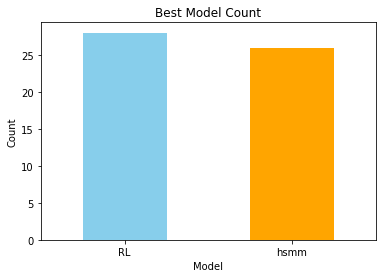

In [56]:
# Count occurrences of each value in 'best_model'
counts = df['best_model'].value_counts()

# Bar plot
counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Best Model Count')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [59]:
forward_hsmm_df["mean"] = forward_hsmm_df["n"] *(1-forward_hsmm_df["p"]) / forward_hsmm_df["p"]

In [62]:
forward_hsmm_df

,Unnamed: 0,n,p,lbound,scale,negll,conf_dist,subject,hbound,mean
0,0,93.334,0.794000,3.735920,0.794302,47.728148,0.743929,45628,4.739981,24.215118
1,1,100.000,0.794000,3.594764,0.668917,32.951445,0.401574,45640,4.534751,25.944584
2,2,6.676,0.336667,3.148277,0.000000,223.361785,1.549730,45664,3.148277,13.153703
3,3,6.676,0.336667,1.720713,0.753974,148.669469,0.752773,45682,4.193208,13.153703
4,4,80.002,0.794000,3.270278,0.917979,93.397290,0.340700,45745,4.858126,20.756186
5,5,6.676,0.271333,1.000000,0.909161,64.414080,0.786559,45760,4.636644,17.928423
6,6,0.010,0.010000,1.607888,0.961157,75.583836,0.707389,45763,4.868239,0.990000
7,7,86.668,0.794000,3.984532,0.958155,77.154918,0.203101,45805,4.957508,22.485652
8,8,13.342,0.402000,1.103421,0.821636,103.728616,0.711147,45829,4.304991,19.847055
9,9,6.676,0.402000,2.429462,0.691609,150.161206,1.044057,45964,4.207269,9.930965


<AxesSubplot:xlabel='mean', ylabel='Count'>

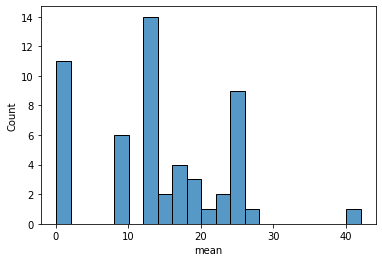

In [67]:
sns.histplot(data=forward_hsmm_df, x="mean", binwidth=2)

<AxesSubplot:xlabel='mean', ylabel='Count'>

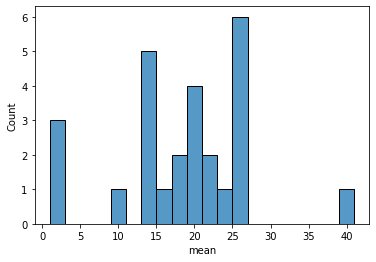

In [68]:
sns.histplot(data=forward_hsmm_df[df["best_model"]=="hsmm"], x="mean", binwidth=2)

In [72]:
df['min_neg_LL'] = df[['LL', 'negll']].min(axis=1)


In [85]:
new_forward = forward_df[["subject","LL"]].rename(columns={"LL":"negll"})
new_hsmm = forward_hsmm_df[["subject", "negll"]].rename(columns={"LL":"negll"})
new_mixture = df[["subject", "min_neg_LL"]].rename(columns={"min_neg_LL": "negll"})

In [88]:


dataframes = [new_forward, new_hsmm, new_mixture]

groups = ["RL", "HSMM", "Mixture"]

avg_df = merge_result_df(dataframes, groups, 200, subjects)

# Rename columns in the merged DataFrame


Statistics for HSMM and RL =691.0, p=6.575e-01
Statistics for HSMM and Mixture =0.0, p=3.790e-06
Statistics for RL and Mixture =0.0, p=8.298e-06
mean RL = 110.12
mean HSMM = 111.03
mean Mixture = 97.28


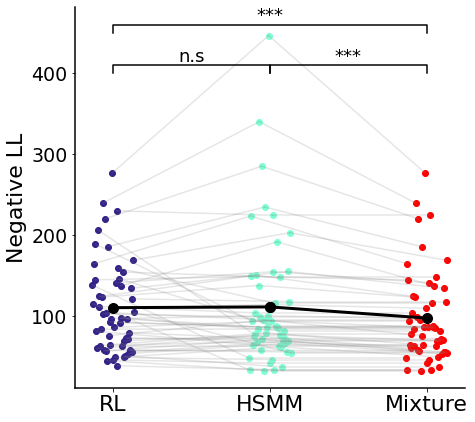

In [97]:
plt.figure(figsize=(7, 7))



color_dict = {"HSMM": "#7FFFD4", "RL": "#332288", "Mixture": "red"}

comparison_plot(
    avg_df,
    "negll",
    groups,
    "",
    [["HSMM", "RL"], ["HSMM", "Mixture"], ["RL", "Mixture"]],
    [400, 400, 450],
    [10, 10, 10],
    y_label="Negative LL",
    color_dict = color_dict
)

In [136]:
rl_avg_sim = averaged_dataframes[0]
hsmm_avg_sim = averaged_dataframes[-1]

mixture_sim_rows = []
for subject in subjects:
    if df[df["subject"] == subject].iloc[0]["best_model"] == "hsmm":
        mixture_sim_rows.append(hsmm_avg_sim[hsmm_avg_sim["subject"]== subject].iloc[0])
    else: 
        mixture_sim_rows.append(rl_avg_sim[rl_avg_sim["subject"]== subject].iloc[0])
mixture_sim_df = pd.DataFrame(mixture_sim_rows)

averaged_sim_dataframes = averaged_dataframes + [mixture_sim_df]
groups = ["RL", "Empirical","HSMM", "Mixture"]
merged_sim_df = merge_result_df(averaged_sim_dataframes, groups, 200, subjects)

merged_sim_df.rename(columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"}, inplace=True)


Statistics for Empirical and RL =7.0, p=2.407e-10
Statistics for HSMM and Empirical =686.5, p=9.818e-01
Statistics for Empirical and Mixture =130.0, p=3.553e-07
mean RL = 0.76
mean Empirical = 0.86
mean HSMM = 0.87
mean Mixture = 0.82


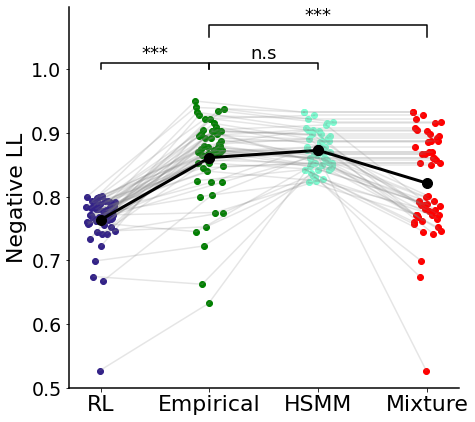

In [137]:
plt.figure(figsize=(7, 7))



color_dict = {"HSMM": "#7FFFD4", "RL": "#332288", "Mixture": "red", "Empirical": "green"}

comparison_plot(
    merged_sim_df,
    "accuracy",
    groups,
    "",
    [["Empirical", "RL"], ["HSMM", "Empirical"], ["Empirical", "Mixture"]],
    [1, 1, 1.05],
    [0.01, 0.01, 0.02],
    y_label="Negative LL",
    color_dict = color_dict
)

In [138]:
mixture_sim_df.to_csv("../results/mixture_sim_df.csv")

In [140]:
df.to_csv("../results/Rl_HSMM_merged.csv")